In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install pytorch-lightning
import pytorch_lightning as pl
import pandas as pd
import cv2
import os 
from torch import nn
from torch.utils.data import Dataset ,DataLoader
import numpy as np
import torch
from sklearn.model_selection import train_test_split 
from torchvision import transforms, datasets

In [4]:
import matplotlib.pyplot as plt
pl.seed_everything(7)


PATH_DATASETS = os.environ.get("PATH_DATASETS", "/content/drive/MyDrive/Datasets")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

Global seed set to 7


In [13]:
import torchmetrics
from torchmetrics.functional import accuracy
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

In [9]:
class LitCnn(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.layer1 = nn.Sequential(self.conv1, nn.ReLU(), nn.MaxPool2d(kernel_size=2))
    self.layer2 = nn.Sequential(self.conv2, nn.ReLU(), nn.MaxPool2d(kernel_size=2))
    self.out = nn.Linear(32*7*7, 10)
    self.save_hyperparameters()

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)

    x = x.view(x.size(0), -1)
    output = self.out(x)

    return output

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = nn.functional.cross_entropy(logits, y)
    self.log('train loss', loss)
    return loss

  def evaluate(self, batch, stage=None):
    x, y = batch
    logits = self.forward(x)
    loss = nn.functional.cross_entropy(logits, y)
    preds = torch.argmax(logits, dim=1)
    acc = accuracy(preds, y)

    if stage:
      self.log(f"{stage}_loss", loss, prog_bar=True)
      self.log(f"{stage}_acc", acc, prog_bar=True)

  def validation_step(self, batch, batch_idx):
    self.evaluate(batch, "val")

  def test_step(self, batch, batch_idx):
    self.evaluate(batch, "test")

  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(), lr=1e-2)



In [28]:
class LitKMNIST(pl.LightningDataModule):
  def prepare_data(self) -> None:
      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.1307,), (0.3081,))
      ])

      self.kmnist_train = datasets.KMNIST("/content/drive/MyDrive/Datasets", train=True, download=True, 
                                          transform=transform)
      
      self.kmnist_test = datasets.KMNIST("/content/drive/MyDrive/Datasets", train=False, download=True, 
                                          transform=transform)
      

  def train_dataloader(self):
    return DataLoader(self.kmnist_train, batch_size=32)

  def test_dataloader(self):
    return DataLoader(self.kmnist_test, batch_size=32)

  def visualize_sample(self):
    figure = plt.figure(figsize=(10,8))
    cols, rows = 5, 5 
    for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(self.kmnist_train), size=(1,)).item()
      img, label = self.kmnist_train[sample_idx]
      plt.subplot(rows, cols, i)
      plt.title(label)
      plt.axis('off')
      plt.imshow(img.squeeze(), cmap='gray')
    plt.show()

In [29]:
data_module = LitKMNIST()
data_module.prepare_data()

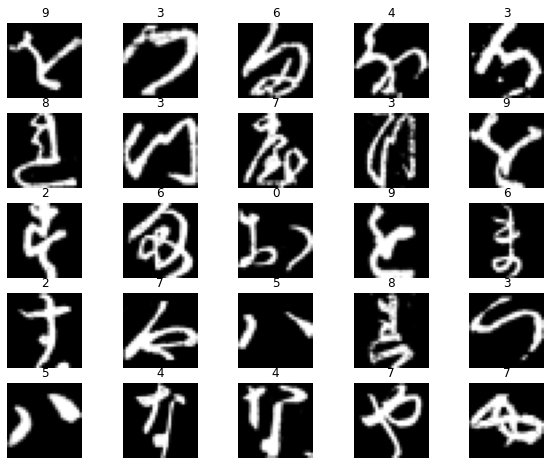

In [12]:
data_module.visualize_sample()

In [17]:
model = LitCnn()
trainer = pl.Trainer(max_epochs=10,
                     default_root_dir="/content/drive/MyDrive/Checkpoints", 
                     accelerator="auto",
                     devices=1 if torch.cuda.is_available() else None,
                     logger=CSVLogger(save_dir="logs/"),
                     callbacks=[LearningRateMonitor(logging_interval="step"),
                                TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model, data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | conv1  | Conv2d     | 416   
1 | conv2  | Conv2d     | 12.8 K
2 | layer1 | Sequential | 416   
3 | layer2 | Sequential | 12.8 K
4 | out    | Linear     | 15.7 K
--------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
0.116     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [20]:
model.load_from_checkpoint("/content/logs/lightning_logs/version_0/checkpoints/epoch=9-step=18750.ckpt")

LitCnn(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [30]:
trainer.test(model, ckpt_path="/content/logs/lightning_logs/version_0/checkpoints/epoch=9-step=18750.ckpt",
             datamodule=data_module)

Restoring states from the checkpoint path at /content/logs/lightning_logs/version_0/checkpoints/epoch=9-step=18750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/logs/lightning_logs/version_0/checkpoints/epoch=9-step=18750.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8371999859809875
        test_loss           0.5805139541625977
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8371999859809875, 'test_loss': 0.5805139541625977}]